In [1]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
from data import *
from config import *
from classifer import *
from describer import *
print("using device: ", device)
random_state = 333
import pandas as pd
from sklearn.model_selection import train_test_split

# for debugging
# import importlib
# import models
# importlib.reload(models)


Random seed set to 333
using device:  cpu


In [3]:
# # ---- update configs ----
# overwrite = True
# model_name = 'binary_hr_death'
# text_config['cl']['die7d'] = True # udpate text_config here if needed
# txt_ls = ['will die', 'will survive']

# update_config(
#     model_name = model_name,
#     ts_aug = False,
#     ts_normalize = False,
#     ts_encode = False,
#     balance = False,
#     block_target = False,
#     txt_ls = txt_ls,
#     patience = 20,
#     num_saves = 20,
#     num_epochs = 100,
#     text_config = text_config
# )
# config_dict = get_config_dict()
# config_dict

In [4]:
# -----------------Train Data-----------------
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.5s
[Parallel(n_jobs=9)]: Done 5138 tasks      | elapsed:    5.5s
[Parallel(n_jobs=9)]: Done 63457 tasks      | elapsed:   13.9s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   14.1s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  No Bradycardia events.   Very low amount of consecutive increases. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.0s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    7.7s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    7.8s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  No Bradycardia events.  It shows high variability.  Low amount of consecutive increases. 


In [5]:
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']
y_col = 'cl_event'
# ---- downsample negative class(es) ----
# sample 5000 rows from df_test[df_test[y_col]==txt_ls_org[1]], without replacement
neg_sample_size = 1000
df_test_downsampled = df_test[df_test[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_test = pd.concat([df_test[df_test[y_col]==txt_ls_org[0]], df_test_downsampled])
df_train_downsampled = df_train[df_train[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_train = pd.concat([df_train[df_train[y_col]==txt_ls_org[0]], df_train_downsampled])


# ---- augment + balance train data----
target_event_rate = len(df_test[df_test[y_col]==txt_ls_org[0]])/len(df_test)
max_size = int(target_event_rate*len(df_train))
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    txt_ls_org, 
                                    y_col, 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth', 
                                    K=10,
                                    max_size=max_size)


# ---- block or not ----
# important for generating labels for block target
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    df_train['label'] = df_train['rowid'].astype(int)
    df_test['label'] = df_test['rowid'].astype(int)

def get_y_true_and_ts_df(df_new, txt_ls_org):
    df_new_y = pd.get_dummies(df_new['cl_event'])
    df_new_y = df_new_y[txt_ls_org]
    y_true = torch.tensor(df_new_y.values)
    ts_df = df_new.loc[:,'1':'300']
    return y_true, ts_df


# ---- prepare for binary classification evaluation ----
y_true_train, ts_df_train = get_y_true_and_ts_df(df_train, txt_ls_org)     # create y_true_train and ts_df_train
y_true_test, ts_df_test = get_y_true_and_ts_df(df_test, txt_ls_org)     # create y_true_test and ts_df_test
print(ts_df_train.shape)
print(ts_df_test.shape)


y_true_train = y_true_train.float()
y_true_test = y_true_test.float() 
train_loader = prepare_basedata(ts_df_train, y_true_train)
test_loader = prepare_basedata(ts_df_test, y_true_test)

# get number of positives in y_true_train
pos_count = (y_true_train[:,0] == 1).sum().item()
print(f"Number of positives in y_true_train: {pos_count}")

# get number of positives in y_true_test
pos_count = (y_true_test[:,0] == 1).sum().item()
print(f"Number of positives in y_true_test: {pos_count}")


(1384, 300)
(1241, 300)
Number of positives in y_true_train: 384
Number of positives in y_true_test: 241


# baseline models to predict clinical outcomes end2end

In [6]:
# # Create different types of models
# resnet_encoder = ResNetEncoder(ts_dim=300, output_dim=128, dropout=0.1)
# model = GeneralBinaryClassifier(resnet_encoder)

# resnet_encoder = ResNetEncoder(ts_dim=300, output_dim=128, num_blocks=16, dropout=0.1)
# model = GeneralBinaryClassifier(resnet_encoder)

# mlp_encoder = MLPEncoder(ts_dim=300, output_dim=12, num_hidden_layers=0, dropout=0.5)
# model = GeneralBinaryClassifier(mlp_encoder)

# cnn_encoder = CNNEncoder(ts_dim=300, output_dim=128, num_channels=[64, 64, 128, 128, 256, 256, 512, 512])
# model = GeneralBinaryClassifier(cnn_encoder)

# lstm_encoder = LSTMEncoder(ts_dim=300, output_dim=128, num_layers=1, hidden_dim=16, dropout=0.5)
# model = GeneralBinaryClassifier(lstm_encoder)

lstm_encoder = MultiLSTMEncoder(
    ts_dim=300, 
    output_dim=128,
    hidden_dims=[128, 128],  # Three LSTMs with different sizes
    num_layers=2
)
model = GeneralBinaryClassifier(lstm_encoder)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=20,          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)


Layer (type:depth-idx)                   Param #
GeneralBinaryClassifier                  --
├─MultiLSTMEncoder: 1-1                  --
│    └─ModuleList: 2-1                   --
│    │    └─LSTM: 3-1                    352,256
│    │    └─LSTM: 3-2                    352,256
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-3                  32,896
│    │    └─BatchNorm1d: 3-4             256
│    │    └─LeakyReLU: 3-5               --
│    │    └─Dropout: 3-6                 --
│    │    └─Linear: 3-7                  16,512
│    │    └─BatchNorm1d: 3-8             256
├─Linear: 1-2                            258
Total params: 754,690
Trainable params: 754,690
Non-trainable params: 0


In [7]:

eval_dic_tmp, train_losses_tmp, test_losses_tmp = train_binary_classifier(model, 
                                                train_loader,
                                                test_loader, 
                                                optimizer, 
                                                scheduler,
                                                400, 
                                                device)

Epoch [1/400]
	Train Loss: 0.7409	Test Loss: 0.7069
	Train F1: 0.4344	Test F1: 0.3252
	Train AUROC: 0.6146	Test AUROC: 0.5477
	Train AUPRC: 0.3933	Test AUPRC: 0.2287
	Learning Rate: 0.000100000
Epoch [2/400]
	Train Loss: 0.6666	Test Loss: 0.7370
	Train F1: 0.4344	Test F1: 0.3252
	Train AUROC: 0.7225	Test AUROC: 0.5927
	Train AUPRC: 0.4943	Test AUPRC: 0.2812
	Learning Rate: 0.000100000
Epoch [3/400]
	Train Loss: 0.6334	Test Loss: 0.7519
	Train F1: 0.4344	Test F1: 0.3252
	Train AUROC: 0.7736	Test AUROC: 0.6027
	Train AUPRC: 0.5517	Test AUPRC: 0.2917
	Learning Rate: 0.000100000
Epoch [4/400]
	Train Loss: 0.6118	Test Loss: 0.7573
	Train F1: 0.4381	Test F1: 0.3265
	Train AUROC: 0.8091	Test AUROC: 0.5970
	Train AUPRC: 0.5911	Test AUPRC: 0.2829
	Learning Rate: 0.000100000
Epoch [5/400]
	Train Loss: 0.5976	Test Loss: 0.7579
	Train F1: 0.4707	Test F1: 0.3248
	Train AUROC: 0.8425	Test AUROC: 0.5991
	Train AUPRC: 0.6459	Test AUPRC: 0.2861
	Learning Rate: 0.000100000
Epoch [6/400]
	Train Loss: 0.5

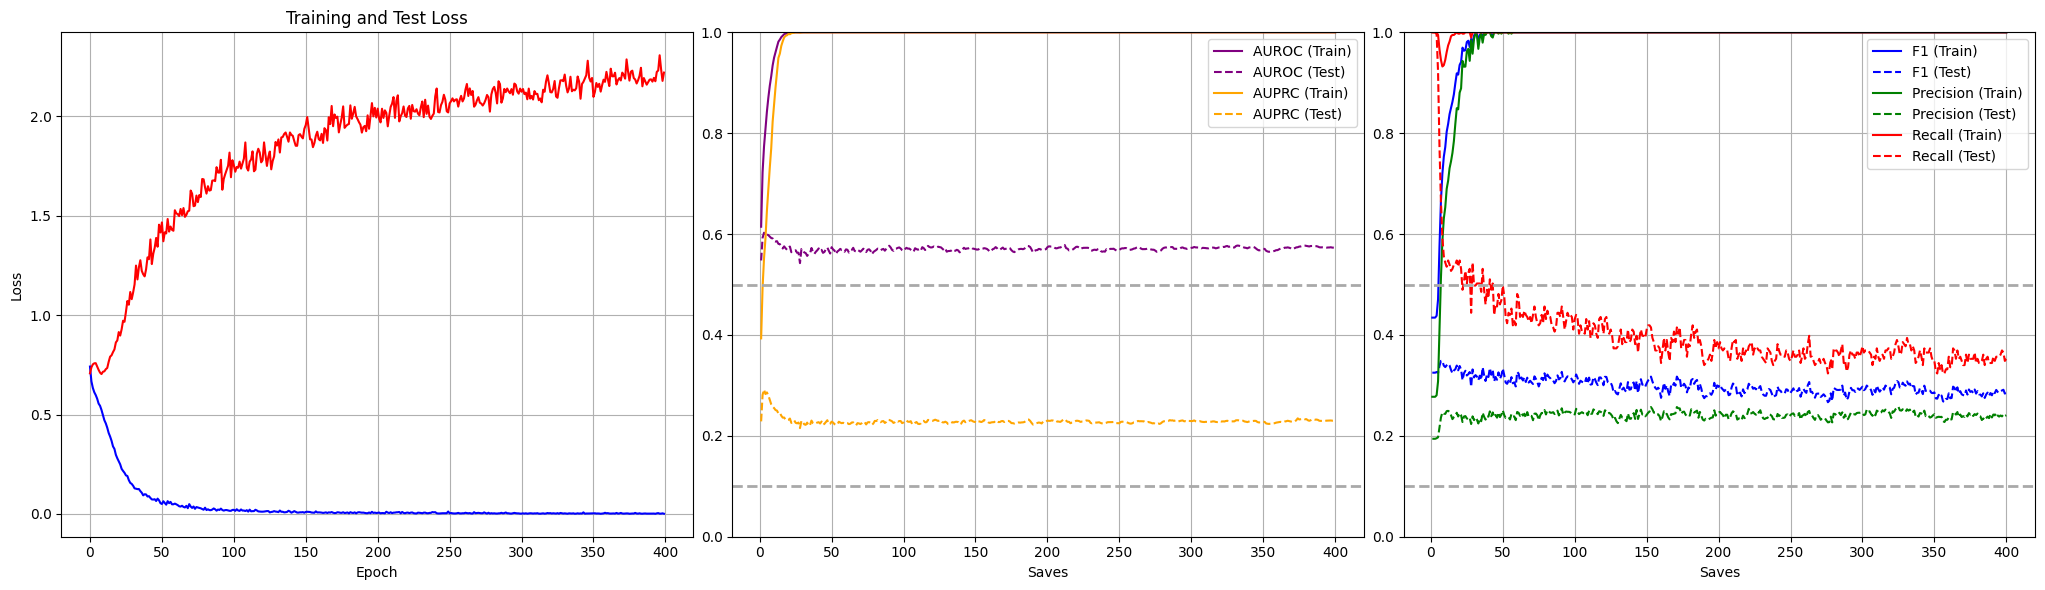

In [9]:
eval_dict_eng = eng_eval_metrics(eval_dic_tmp, binary=True)